<a href="https://colab.research.google.com/github/sdgroeve/D012554_Machine_Learning_2023/blob/main/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

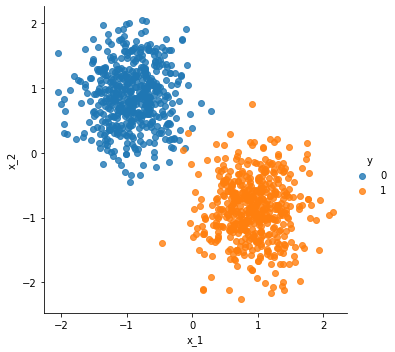

In [1]:
#creating the dataset

from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns

X, y = make_blobs(n_samples=1000, centers=2, cluster_std=2, n_features=2, random_state=9)

X = StandardScaler().fit_transform(X)

tmp = pd.DataFrame(X,columns=["x_1","x_2"])
tmp["y"] = y

sns.lmplot(x="x_1",y="x_2",hue="y",data=tmp,fit_reg=False)

tmp.to_csv("dataset_logistic_regression.csv",index=False)


In [2]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1. A basic workflow


We will make use of the [PyTorch](https://pytorch.org/) open source machine learning framework to code predictive models. 

We import the PyTorch libraries as follows:

In [3]:
import torch
from torch import nn 

torch.manual_seed(46)

# Check PyTorch version
torch.__version__

'1.13.1+cu116'

A tyical PyTorch workflow involves:

1. Preparing the data
2. Building a model
3. Fitting the model to the data (training)
4. Computing predictions and evaluating the model
5. Saving and loading the model
6. Putting it all together

Let's discuss these steps in more detail by fitting a logistic regression model with PyTorch.

## 1. Preparing the data

The data is in a `.csv` file called `dataset_logistic_regression`. We load this data into a Pandas DataFrame.



In [4]:
import pandas as pd

dataset = pd.read_csv("dataset_logistic_regression.csv")

dataset.head()

,x_1,x_2,y
0,-1.385532,0.930333,0
1,0.470672,-0.645184,1
2,1.109673,-0.775433,1
3,-0.921845,0.623731,0
4,1.625524,-0.874740,1


This dataset as two features `x_1` and `x_2`, and one label `y`. Let's plot this dataset. 

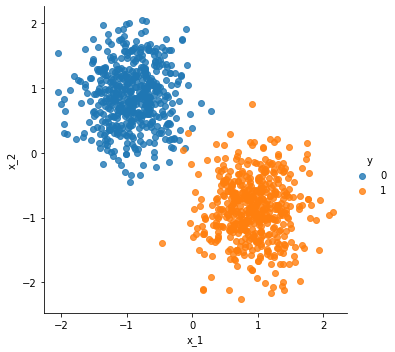

In [5]:
import seaborn as sns

sns.lmplot(x="x_1",y="x_2",hue="y",data=dataset,fit_reg=False)

We put the feature columns in a DataFrame called `X` and the label column in a DataFrame called `y`.

In [6]:
y = dataset.pop('y')
X = dataset

One of most important steps in a machine learning project is creating a training and test set (and when required, a validation set).

Each split of the dataset serves a specific purpose:

| Split | Purpose | Amount of total data | How often is it used? |
| ----- | ----- | ----- | ----- |
| **Training set** | The model learns from this data. | ~60-80% | Always |
| **Validation set** | The model gets tuned on this data. | ~10-20% | Often but not always |
| **Testing set** | The model gets evaluated on this data to test what it has learned. | ~10-20% | Always |

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
X_train

,x_1,x_2
29,-1.093640,0.255102
535,-0.784692,0.910518
695,1.060577,-0.913586
557,-0.638682,0.683802
836,0.517858,-0.402780
...,...,...
106,2.096312,-0.962312
270,-0.769492,2.046732
860,0.967041,-1.341369
435,0.893886,-0.850858


In [9]:
X_train, X_test = X_train.values, X_test.values
y_train, y_test = y_train.values, y_test.values

In [10]:
X_train

array([[-1.09364013,  0.25510156],
       [-0.78469195,  0.91051752],
       [ 1.06057683, -0.91358588],
       ...,
       [ 0.96704068, -1.34136883],
       [ 0.89388643, -0.85085827],
       [-1.33275052,  0.3117806 ]])

In [11]:
X_train, X_test = torch.Tensor(X_train),torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train),torch.Tensor(y_test)

## 2. Building a model

Let's build a standard logistic regression model using pure PyTorch.

In [12]:
class LogisticRegression(torch.nn.Module):

  def __init__(self, input_dim, output_dim):
    super(LogisticRegression, self).__init__()
    self.linear = torch.nn.Linear(input_dim, output_dim)   
    torch.nn.init.uniform_(self.linear.weight) 

  def forward(self, x):
    outputs = torch.sigmoid(self.linear(x))
    return outputs

Alright there's a fair bit going on above but let's break it down bit by bit.

PyTorch has four (give or take) essential modules you can use to create almost any kind of neural network you can imagine.

They are [`torch.nn`](https://pytorch.org/docs/stable/nn.html), [`torch.optim`](https://pytorch.org/docs/stable/optim.html), [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) and [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html). For now, we'll focus on the first two and get to the other two later (though you may be able to guess what they do).

| PyTorch module | What does it do? |
| ----- | ----- |
| [`torch.nn`](https://pytorch.org/docs/stable/nn.html) | Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way). |
| [`torch.nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#parameter) | Stores tensors that can be used with `nn.Module`. If `requires_grad=True` gradients (used for updating model parameters via [**gradient descent**](https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html))  are calculated automatically, this is often referred to as "autograd".  | 
| [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module) | The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass `nn.Module`. Requires a `forward()` method be implemented. | 
| [`torch.optim`](https://pytorch.org/docs/stable/optim.html) | Contains various optimization algorithms (these tell the model parameters stored in `nn.Parameter` how to best change to improve gradient descent and in turn reduce the loss). | 
| `def forward()` | All `nn.Module` subclasses require a `forward()` method, this defines the computation that will take place on the data passed to the particular `nn.Module` (e.g. the linear regression formula above). |

If the above sounds complex, think of like this, almost everything in a PyTorch neural network comes from `torch.nn`,
* `nn.Module` contains the larger building blocks (layers)
* `nn.Parameter` contains the smaller parameters like weights and biases (put these together to make `nn.Module`(s))
* `forward()` tells the larger blocks how to make calculations on inputs (tensors full of data) within  `nn.Module`(s)
* `torch.optim` contains optimization methods on how to improve the parameters within `nn.Parameter` to better represent input data 

![a pytorch linear model with annotations](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-linear-model-annotated.png)
*Basic building blocks of creating a PyTorch model by subclassing `nn.Module`. For objects that subclass `nn.Module`, the `forward()` method must be defined.*

In [13]:
# Two inputs x_1 and x_2
input_dim = 2  
# Single binary output 
output_dim = 1 

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LogisticRegression(input_dim, output_dim)

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([[0.1596, 0.7550]], requires_grad=True), Parameter containing:
 tensor([0.0246], requires_grad=True)]


### Checking the contents of a PyTorch model
Now we've got these out of the way, let's create a model instance with the class we've made and check its parameters using [`.parameters()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.parameters). 

We can also get the state (what the model contains) of the model using [`.state_dict()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.state_dict).

In [14]:
# List named parameters 
model_0.state_dict()

OrderedDict([('linear.weight', tensor([[0.1596, 0.7550]])),
             ('linear.bias', tensor([0.0246]))])

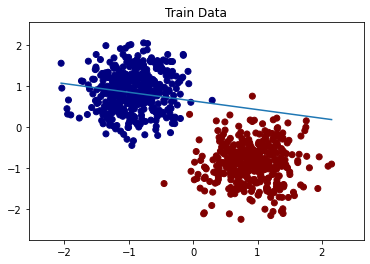

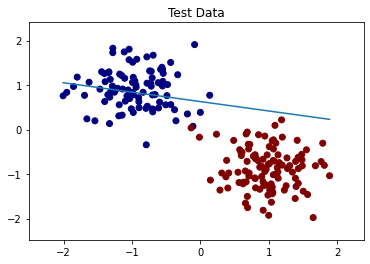

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def model_plot(model,X,y,title):
    parm = {}
    b = []
    for name, param in model.named_parameters():
        parm[name]=param.detach().numpy()  
    
    w = parm['linear.weight'][0]
    b = parm['linear.bias'][0]
    plt.scatter(X[:, 0], X[:, 1], c=y,cmap='jet')
    u = np.linspace(X[:, 0].min(), X[:, 0].max(), 2)
    plt.plot(u, (0.5-b-w[0]*u)/w[1])
    plt.xlim(X[:, 0].min()-0.5, X[:, 0].max()+0.5)
    plt.ylim(X[:, 1].min()-0.5, X[:, 1].max()+0.5)
    plt.title(title)
    plt.show()


# Train Data
model_plot(model_0,X_train,y_train,'Train Data')
model_plot(model_0,X_test,y_test,'Test Data')

### Making predictions using `torch.inference_mode()` 
To check this we can pass it the test data `X_test` to see how closely it predicts `y_test`.

When we pass data to our model, it'll go through the model's `forward()` method and produce a result using the computation we've defined. 

Let's make some predictions. 

In [22]:
from sklearn import metrics

# Make predictions with model
with torch.inference_mode(): 
    y_preds = model_0(X_test)

outputs_test = torch.squeeze(y_preds)
predicted_test = outputs_test.round().detach().numpy()

print(metrics.accuracy_score(y_test,predicted_test))

0.08


You probably noticed we used [`torch.inference_mode()`](https://pytorch.org/docs/stable/generated/torch.inference_mode.html) as a [context manager](https://realpython.com/python-with-statement/) (that's what the `with torch.inference_mode():` is) to make the predictions.

As the name suggests, `torch.inference_mode()` is used when using a model for inference (making predictions).

`torch.inference_mode()` turns off a bunch of things (like gradient tracking, which is necessary for training but not for inference) to make **forward-passes** (data going through the `forward()` method) faster.

## 3. Train model

Right now our model is making predictions using random parameters to make calculations, it's basically guessing (randomly).

To fix that, we can update its internal parameters (I also refer to *parameters* as patterns), the `weights` and `bias` values we set randomly using `nn.Parameter()` and `torch.randn()` to be something that better represents the data.

We could hard code this (since we know the default values `weight=0.7` and `bias=0.3`) but where's the fun in that?

Much of the time you won't know what the ideal parameters are for a model.

Instead, it's much more fun to write code to see if the model can try and figure them out itself.



### Creating a loss function and optimizer in PyTorch

For our model to update its parameters on its own, we'll need to add a few more things to our recipe.

And that's a **loss function** as well as an **optimizer**.

The rolls of these are: 

| Function | What does it do? | Where does it live in PyTorch? | Common values |
| ----- | ----- | ----- | ----- |
| **Loss function** | Measures how wrong your models predictions (e.g. `y_preds`) are compared to the truth labels (e.g. `y_test`). Lower the better. | PyTorch has plenty of built-in loss functions in [`torch.nn`](https://pytorch.org/docs/stable/nn.html#loss-functions). | Mean absolute error (MAE) for regression problems ([`torch.nn.L1Loss()`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html)). Binary cross entropy for binary classification problems ([`torch.nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)).  |
| **Optimizer** | Tells your model how to update its internal parameters to best lower the loss. | You can find various optimization function implementations in [`torch.optim`](https://pytorch.org/docs/stable/optim.html). | Stochastic gradient descent ([`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)). Adam optimizer ([`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)). | 

Let's create a loss function and an optimizer we can use to help improve our model.

Depending on what kind of problem you're working on will depend on what loss function and what optimizer you use.

However, there are some common values, that are known to work well such as the SGD (stochastic gradient descent) or Adam optimizer. And the MAE (mean absolute error) loss function for regression problems (predicting a number) or binary cross entropy loss function for classification problems (predicting one thing or another). 

For our problem, since we're predicting a number, let's use MAE (which is under `torch.nn.L1Loss()`) in PyTorch as our loss function. 

![what MAE loss looks like for our plot data](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-mae-loss-annotated.png)
*Mean absolute error (MAE, in PyTorch: `torch.nn.L1Loss`) measures the absolute difference between two points (predictions and labels) and then takes the mean across all examples.*

And we'll use SGD, `torch.optim.SGD(params, lr)` where:

* `params` is the target model parameters you'd like to optimize (e.g. the `weights` and `bias` values we randomly set before).
* `lr` is the **learning rate** you'd like the optimizer to update the parameters at, higher means the optimizer will try larger updates (these can sometimes be too large and the optimizer will fail to work), lower means the optimizer will try smaller updates (these can sometimes be too small and the optimizer will take too long to find the ideal values). The learning rate is considered a **hyperparameter** (because it's set by a machine learning engineer). Common starting values for the learning rate are `0.01`, `0.001`, `0.0001`, however, these can also be adjusted over time (this is called [learning rate scheduling](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)). 

Woah, that's a lot, let's see it in code.

In [25]:
learning_rate = 0.003

model = LogisticRegression(input_dim,output_dim)

loss_func = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Creating an optimization loop in PyTorch

Woohoo! Now we've got a loss function and an optimizer, it's now time to create a **training loop** (and **testing loop**).

The training loop involves the model going through the training data and learning the relationships between the `features` and `labels`.

The testing loop involves going through the testing data and evaluating how good the patterns are that the model learned on the training data (the model never see's the testing data during training).

Each of these is called a "loop" because we want our model to look (loop through) at each sample in each dataset.

To create these we're going to write a Python `for` loop in the theme of the [unofficial PyTorch optimization loop song](https://twitter.com/mrdbourke/status/1450977868406673410?s=20) (there's a [video version too](https://youtu.be/Nutpusq_AFw)).

![the unofficial pytorch optimization loop song](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-optimization-loop-song.png)
*The unoffical PyTorch optimization loops song, a fun way to remember the steps in a PyTorch training (and testing) loop.*

There will be a fair bit of code but nothing we can't handle.




### PyTorch training loop
For the training loop, we'll build the following steps:

| Number | Step name | What does it do? | Code example |
| ----- | ----- | ----- | ----- |
| 1 | Forward pass | The model goes through all of the training data once, performing its `forward()` function calculations. | `model(x_train)` |
| 2 | Calculate the loss | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_train)` | 
| 3 | Zero gradients | The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step. | `optimizer.zero_grad()` |
| 4 | Perform backpropagation on the loss | Computes the gradient of the loss with respect for every model parameter to be updated  (each parameter with `requires_grad=True`). This is known as **backpropagation**, hence "backwards".  | `loss.backward()` |
| 5 | Update the optimizer (**gradient descent**) | Update the parameters with `requires_grad=True` with respect to the loss gradients in order to improve them. | `optimizer.step()` |

![pytorch training loop annotated](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-training-loop-annotated.png)

> **Note:** The above is just one example of how the steps could be ordered or described. With experience you'll find making PyTorch training loops can be quite flexible.
>
> And on the ordering of things, the above is a good default order but you may see slightly different orders. Some rules of thumb: 
> * Calculate the loss (`loss = ...`) *before* performing backpropagation on it (`loss.backward()`).
> * Zero gradients (`optimizer.zero_grad()`) *before* stepping them (`optimizer.step()`).
> * Step the optimizer (`optimizer.step()`) *after* performing backpropagation on the loss (`loss.backward()`).

For resources to help understand what's happening behind the scenes with backpropagation and gradient descent, see the extra-curriculum section.



### PyTorch testing loop

As for the testing loop (evaluating our model), the typical steps include:

| Number | Step name | What does it do? | Code example |
| ----- | ----- | ----- | ----- |
| 1 | Forward pass | The model goes through all of the training data once, performing its `forward()` function calculations. | `model(x_test)` |
| 2 | Calculate the loss | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_test)` | 
| 3 | Calulate evaluation metrics (optional) | Alongisde the loss value you may want to calculate other evaluation metrics such as accuracy on the test set. | Custom functions |

Notice the testing loop doesn't contain performing backpropagation (`loss.backward()`) or stepping the optimizer (`optimizer.step()`), this is because no parameters in the model are being changed during testing, they've already been calculated. For testing, we're only interested in the output of the forward pass through the model.

![pytorch annotated testing loop](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-testing-loop-annotated.png)

Let's put all of the above together and train our model for 100 **epochs** (forward passes through the data) and we'll evaluate it every 10 epochs.


In [35]:
num_epochs = 20

losses = []
losses_test = []
for epoch in range(num_epochs):

    optimizer.zero_grad() # Setting our stored gradients equal to zero

    loss = loss_func(torch.squeeze(model(X_train)), y_train) 
    print("training loss: %f"%(loss))    

    loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias
    
    optimizer.step() # Updates weights and biases with the optimizer (SGD)
    
    #model_plot(model,X_train,y_train,'Train Data')
    
    predicted_test = torch.squeeze(model(X_test)).round().detach().numpy()
    print(metrics.accuracy_score(y_test,predicted_test))

    predicted_train = torch.squeeze(model(X_train)).round().detach().numpy()
    print(metrics.accuracy_score(y_train,predicted_train))


training loss: 2473.903320
0.995
0.99875
training loss: 2473.854004
0.995
0.99875
training loss: 2473.806152
0.995
0.99875
training loss: 2473.758789
0.995
0.99875
training loss: 2473.712402
0.995
0.99875
training loss: 2473.666992
0.995
0.99875
training loss: 2473.622559
0.995
0.99875
training loss: 2473.579102
0.995
0.99875
training loss: 2473.536377
0.995
0.99875
training loss: 2473.494873
0.995
0.99875
training loss: 2473.453857
0.995
0.99875
training loss: 2473.413574
0.995
0.99875
training loss: 2473.374512
0.995
0.99875
training loss: 2473.335938
0.995
0.99875
training loss: 2473.298096
0.995
0.99875
training loss: 2473.260986
0.995
0.99875
training loss: 2473.224609
0.995
0.99875
training loss: 2473.188477
0.995
0.99875
training loss: 2473.153320
0.995
0.99875
training loss: 2473.118896
0.995
0.99875


Oh would you look at that! Looks like our loss is going down with every epoch, let's plot it to find out.

In [28]:
tmp = pd.DataFrame(list(zip(losses,losses_test)),columns=["train","test"])

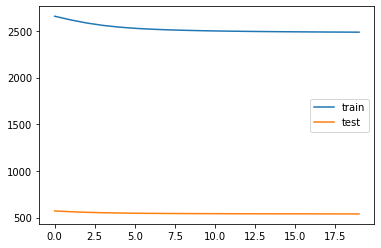

In [30]:
tmp.plot()

Nice! The **loss curves** show the loss going down over time. Remember, loss is the measure of how *wrong* your model is, so the lower the better.

But why did the loss go down?

Well, thanks to our loss function and optimizer, the model's internal parameters (`weights` and `bias`) were updated to better reflect the underlying patterns in the data.

Let's inspect our model's [`.state_dict()`](https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html) to see see how close our model gets to the original values we set for weights and bias.



## 4. Making predictions with a trained PyTorch model (inference)

Once you've trained a model, you'll likely want to make predictions with it.

We've already seen a glimpse of this in the training and testing code above, the steps to do it outside of the training/testing loop are similar.

There are three things to remember when making predictions (also called performing inference) with a PyTorch model:

1. Set the model in evaluation mode (`model.eval()`).
2. Make the predictions using the inference mode context manager (`with torch.inference_mode(): ...`).
3. All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).

The first two items make sure all helpful calculations and settings PyTorch uses behind the scenes during training but aren't necessary for inference are turned off (this results in faster computation). And the third ensures that you won't run into cross-device errors.

In [37]:
# 1. Set the model in evaluation mode
model.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model(X_test)
y_preds

tensor([[1.4504e-03],
        [3.9160e-01],
        [2.1498e-02],
        [1.0822e-02],
        [9.9941e-01],
        [9.9747e-01],
        [2.7874e-04],
        [5.8681e-03],
        [9.7166e-01],
        [1.0540e-01],
        [9.9728e-01],
        [5.3596e-03],
        [9.6669e-01],
        [9.6077e-01],
        [1.4195e-02],
        [9.9788e-01],
        [7.0070e-03],
        [9.8484e-01],
        [9.8962e-01],
        [2.3688e-03],
        [9.9942e-01],
        [8.4037e-03],
        [9.9793e-01],
        [2.1285e-01],
        [1.7212e-03],
        [4.8404e-04],
        [5.3292e-03],
        [9.9968e-01],
        [3.6724e-04],
        [9.9384e-01],
        [9.6167e-01],
        [2.6252e-03],
        [2.4509e-01],
        [1.7680e-02],
        [1.3269e-02],
        [9.9877e-01],
        [9.9512e-01],
        [2.6567e-04],
        [9.8626e-01],
        [4.1387e-03],
        [9.5949e-01],
        [6.2096e-04],
        [9.9651e-01],
        [9.8481e-01],
        [9.8926e-01],
        [2

## 5. Saving and loading a PyTorch model

If you've trained a PyTorch model, chances are you'll want to save it and export it somewhere.

As in, you might train it on Google Colab or your local machine with a GPU but you'd like to now export it to some sort of application where others can use it. 

Or maybe you'd like to save your progress on a model and come back and load it back later.

For saving and loading models in PyTorch, there are three main methods you should be aware of (all of below have been taken from the [PyTorch saving and loading models guide](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference)):

| PyTorch method | What does it do? | 
| ----- | ----- |
| [`torch.save`](https://pytorch.org/docs/stable/torch.html?highlight=save#torch.save) | Saves a serialzed object to disk using Python's [`pickle`](https://docs.python.org/3/library/pickle.html) utility. Models, tensors and various other Python objects like dictionaries can be saved using `torch.save`.  | 
| [`torch.load`](https://pytorch.org/docs/stable/torch.html?highlight=torch%20load#torch.load) | Uses `pickle`'s unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc). |
| [`torch.nn.Module.load_state_dict`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=load_state_dict#torch.nn.Module.load_state_dict)| Loads a model's parameter dictionary (`model.state_dict()`) using a saved `state_dict()` object. | 

> **Note:** As stated in [Python's `pickle` documentation](https://docs.python.org/3/library/pickle.html), the `pickle` module **is not secure**. That means you should only ever unpickle (load) data you trust. That goes for loading PyTorch models as well. Only ever use saved PyTorch models from sources you trust.


### Saving a PyTorch model's `state_dict()`

The [recommended way](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference) for saving and loading a model for inference (making predictions) is by saving and loading a model's `state_dict()`.

Let's see how we can do that in a few steps:

1. We'll create a directory for saving models to called `models` using Python's `pathlib` module.
2. We'll create a file path to save the model to.
3. We'll call `torch.save(obj, f)` where `obj` is the target model's `state_dict()` and `f` is the filename of where to save the model.

> **Note:** It's common convention for PyTorch saved models or objects to end with `.pt` or `.pth`, like `saved_model_01.pth`.


In [38]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models/01_pytorch_workflow_model.pth


In [39]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model.pth

-rw-r--r-- 1 root root 1263 Feb 22 15:32 models/01_pytorch_workflow_model.pth


### Loading a saved PyTorch model's `state_dict()`

Since we've now got a saved model `state_dict()` at `models/01_pytorch_workflow_model_0.pth` we can now load it in using `torch.nn.Module.load_state_dict(torch.load(f))` where `f` is the filepath of our saved model `state_dict()`.

Why call `torch.load()` inside `torch.nn.Module.load_state_dict()`? 

Because we only saved the model's `state_dict()` which is a dictionary of learned parameters and not the *entire* model, we first have to load the `state_dict()` with `torch.load()` and then pass that `state_dict()` to a new instance of our model (which is a subclass of `nn.Module`).

Why not save the entire model?

[Saving the entire model](https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-entire-model) rather than just the `state_dict()` is more intuitive, however, to quote the PyTorch documentation (italics mine):

> The disadvantage of this approach *(saving the whole model)* is that the serialized data is bound to the specific classes and the exact directory structure used when the model is saved...
>
> Because of this, your code can break in various ways when used in other projects or after refactors.

So instead, we're using the flexible method of saving and loading just the `state_dict()`, which again is basically a dictionary of model parameters.

Let's test it out by created another instance of `LinearRegressionModel()`, which is a subclass of `torch.nn.Module` and will hence have the in-built method `load_state_dit()`.

In [41]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model = LogisticRegression(input_dim, output_dim)

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

Excellent! It looks like things matched up.

Now to test our loaded model, let's perform inference with it (make predictions) on the test data.

Remember the rules for performing inference with PyTorch models?

If not, here's a refresher:

<details>
    <summary>PyTorch inference rules</summary>
    <ol>
      <li> Set the model in evaluation mode (<code>model.eval()</code>). </li>
      <li> Make the predictions using the inference mode context manager (<code>with torch.inference_mode(): ...</code>). </li>
      <li> All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).</li>
    </ol> 
</details>



In [42]:
# 1. Put the loaded model into evaluation mode
loaded_model.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model(X_test) # perform a forward pass on the test data with the loaded model

Now we've made some predictions with the loaded model, let's see if they're the same as the previous predictions.

In [43]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        

Nice! 

It looks like the loaded model predictions are the same as the previous model predictions (predictions made prior to saving). This indicates our model is saving and loading as expected.

> **Note:** There are more methods to save and load PyTorch models but I'll leave these for extra-curriculum and further reading. See the [PyTorch guide for saving and loading models](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-and-loading-models) for more. 

* Spend 10-minutes scrolling through and checking out the [PyTorch documentation cheatsheet](https://pytorch.org/tutorials/beginner/ptcheat.html) 